# Parallelisation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukeconibear/swd6_hpp/blob/main/docs/06_parallelisation.ipynb)

In [26]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install dask[dataframe]

## What is it?

Parallelisation divides a large problem into many smaller ones and solves them *simultaneously*.
- *Divides up the time/space complexity across workers.*
- Tasks centrally managed by a scheduler.
- Multi-processing (cores)
    - Useful for compute-bound problems.
    - Don't need to worry about the GIL.  
- Multi-threading (parts of processes)
    - Useful for memory-bound problems.

## Parallelising a Python?

Python itself is not designed for massive scalability and controls threads preemptively using a [Global Interpreter Lock, GIL](https://wiki.python.org/moin/GlobalInterpreterLock). This has lead many libraries to work around this using C/C++ backends. Some options include:
- [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) for creating a pool of asynchronous workers.  
- [joblib](https://joblib.readthedocs.io/en/latest/) for creating lightweight pipelines.  
- [asyncio](https://docs.python.org/3/library/asyncio.html) for concurrent programs.  

These options work well for the CPU cores on your machine, though not really beyond that.  

## [Dask](https://docs.dask.org/en/latest/)

- Great features.
- Helpful documentation.
- Familiar API.
- Under the hood for many libraries e.g. [xarray](http://xarray.pydata.org/en/stable/dask.html), [iris](https://scitools.org.uk/iris/docs/v2.4.0/userguide/real_and_lazy_data.html), [scikit-learn](https://ml.dask.org/).

### [Single machine](https://docs.dask.org/en/latest/setup/single-distributed.html)

See the excellent video from Dask creator, Matthew Rocklin, below.

In [1]:
from IPython.display import IFrame
IFrame(src='https://www.youtube.com/embed/ods97a5Pzw0', width='560', height='315')

In [27]:
client.close()

In [25]:
if not IN_COLAB:
    from dask.distributed import Client
    client = Client()
    client 

distributed.diskutils - INFO - Found stale lock file and directory '/nfs/see-fs-02_users/earlacoa/swd6_hpp/docs/dask-worker-space/worker-ltz7yqu0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nfs/see-fs-02_users/earlacoa/swd6_hpp/docs/dask-worker-space/worker-vjx6i4yt', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nfs/see-fs-02_users/earlacoa/swd6_hpp/docs/dask-worker-space/worker-o1xpf5lv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nfs/see-fs-02_users/earlacoa/swd6_hpp/docs/dask-worker-space/worker-2170deu2', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nfs/see-fs-02_users/earlacoa/swd6_hpp/docs/dask-worker-space/worker-uubxyhzq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nfs/see-fs-02_users/earlacoa/swd6_hpp/docs/dask-worker-space/worker-e1qb6t85', purging
distributed.diskutils - INFO - Found stale lock file and directo

If want multiple threads, then could use keyword arguments in Client instance:
```python
client = Client(processes=False, threads_per_worker=4, n_workers=1)
```

Remember (important), always need to close down the client at the end:
```python
client.close()
```

### Dask behind the scenes

In [1]:
import xarray as xr

In [9]:
ds = xr.tutorial.open_dataset(
    'air_temperature',
    chunks={'time': 'auto'} # dask chunks
)

In [10]:
ds.nbytes * (2 ** -30)

0.014435194432735443

In [15]:
ds_mean = ds.mean()
ds_mean # a dask.array (an unexecuted task graph)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    air      float32 dask.array<chunksize=(), meta=np.ndarray>

In [16]:
ds_mean.compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    air      float32 281.3

In [23]:
ds.close()

### [dask.array](https://examples.dask.org/array.html) (NumPy)
See the excellent video from Dask creator, Matthew Rocklin, below.

In [5]:
IFrame(src='https://www.youtube.com/embed/ZrP-QTxwwnU', width='560', height='315')

In [28]:
import dask.array as da

In [29]:
my_array = da.random.random(
    (50_000, 50_000),
    chunks=(5_000, 5_000) # dask chunks
)
result = my_array + my_array.T
result

dask.array<add, shape=(50000, 50000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>

In [30]:
if not IN_COLAB:
    result.compute()

### [dask.dataframe](https://examples.dask.org/dataframe.html) (Pandas)
See the excellent video from Dask creator, Matthew Rocklin, below.

In [6]:
IFrame(src='https://www.youtube.com/embed/6qwlDc959b0', width='560', height='315')

In [18]:
import dask

In [19]:
df = dask.datasets.timeseries()
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [20]:
type(df)

dask.dataframe.core.DataFrame

In [21]:
result = df.groupby('name').x.std()
result

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 67 tasks

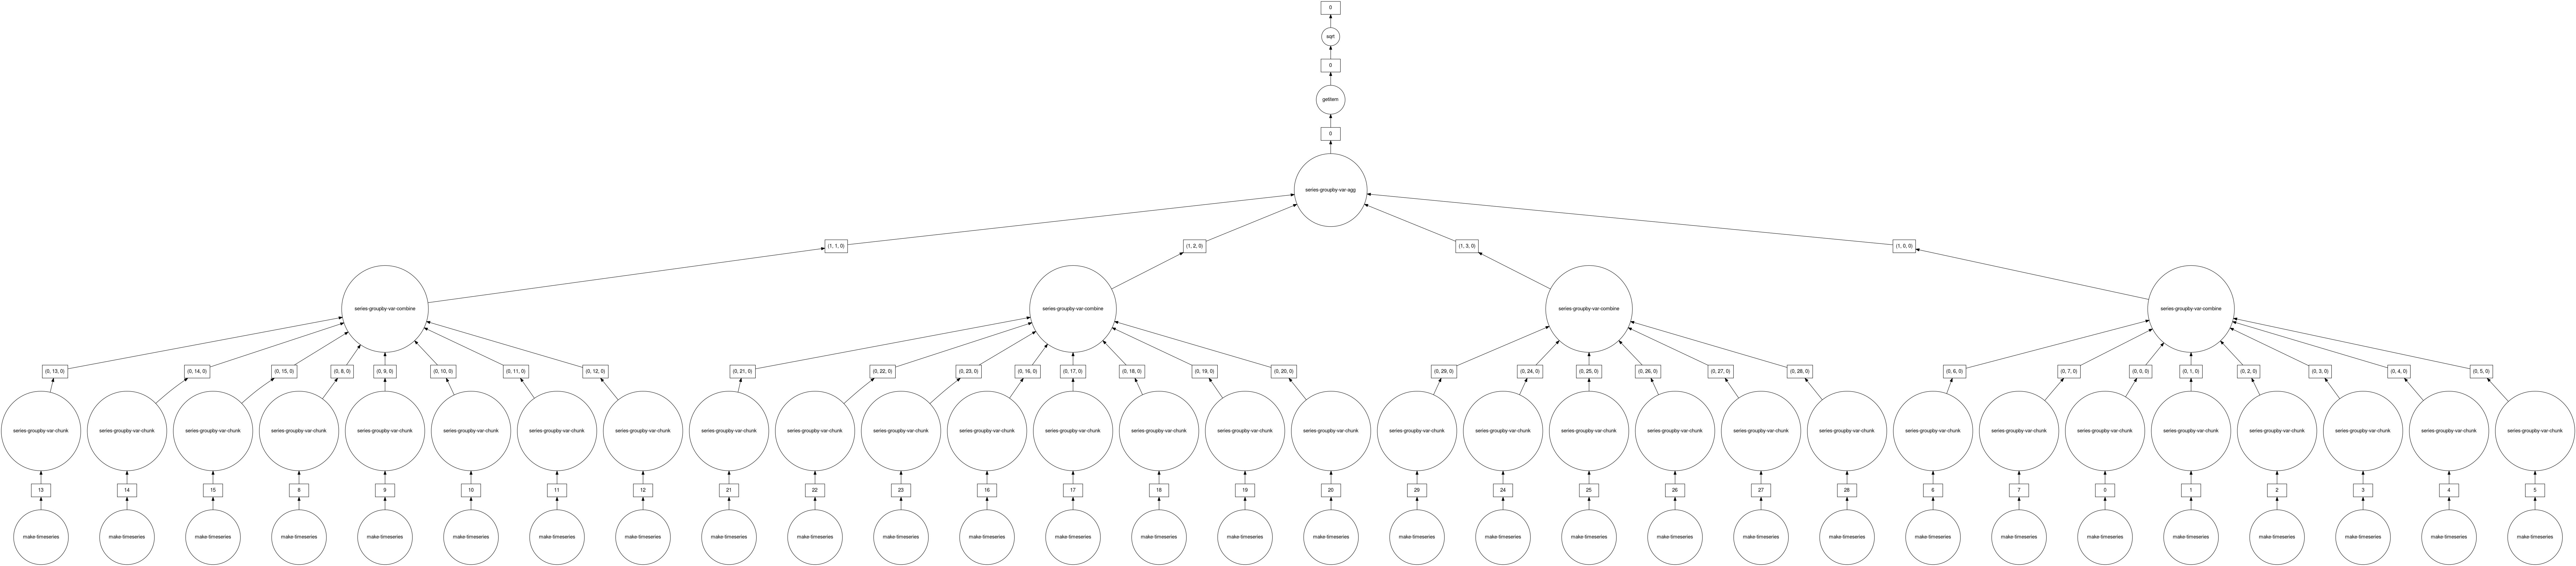

In [22]:
result.visualize()

In [ ]:
result_computed = result.compute()

In [ ]:
type(result_computed)

### [dask.bag](https://examples.dask.org/bag.html)
Iterate over a bag of independent objects (embarrassingly parallel).

In [ ]:
import numpy as np
import dask.bag as db

In [ ]:
nums = np.random.randint(low=0, high=100, size=(5_000_000))
nums

In [ ]:
def weird_function(nums):
    return chr(nums)

In [ ]:
if not IN_COLAB:
    bag = db.from_sequence(nums)
    bag = bag.map(weird_function)
    
    bag.visualize()
    
    result = bag.compute()
    
    client.close()

### [Dask on HPC](https://docs.dask.org/en/latest/setup/hpc.html)

- Non-interactive
- Create/edit the [`dask_on_hpc.py`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/dask_on_hpc.py) file.
- Submit to the queue using [`qsub dask_on_hpc.bash`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/dask_on_hpc.bash).

If need to share memory across chunks:  
- Use [shared memory](https://docs.dask.org/en/latest/shared.html) (commonly OpenMP, Open Multi-Processing).
- `-pe smp np` on ARC4

Otherwise:  
- Use [message passing interface, MPI](https://docs.dask.org/en/latest/setup/hpc.html?highlight=mpi#using-mpi) (commonly OpenMPI).
- `-pe ib np` on ARC4

### [Interactive Jupyter/Dask on HPC](https://pangeo.io/setup_guides/hpc.html)
See the excellent video from Dask creator, Matthew Rocklin, below.
- Create or edit the [`~/.config/dask/jobqueue.yaml`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/jobqueue.yaml) file within this repository.
- Check the [`~/.config/dask/distributed.yaml`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/distributed.yaml) file with this repository.

In [8]:
IFrame(src='https://www.youtube.com/embed/FXsgmwpRExM', width='560', height='315')

```bash
# in a terminal

# log onto arc4
ssh ${USER}@arc4.leeds.ac.uk

# start an interactive session on a compute node on arc4
qlogin -l h_rt=04:00:00 -l h_vmem=12G

# activate your python environment
conda activate my_python_environment

# echo back the ssh command to connect to this compute node
echo "ssh -N -L 2222:`hostname`:2222 -L 2727:`hostname`:2727 ${USER}@arc4.leeds.ac.uk"

# launch a jupyter lab session on this compute node
jupyter lab --no-browser --ip=`hostname` --port=2222
```
___
```bash
# in a local terminal
# ssh into the compute node
ssh -N -L 2222:`hostname`:2222 -L 2727:`hostname`:2727 ${USER}@arc4.leeds.ac.uk
```
___
```bash
# open up a local browser (e.g. chrome)
# go to the jupyter lab session by pasting into the url bar
localhost:2222
    
# can also load the dask dashboard in the browser at localhost:2727
```
___
```bash
# now the jupyter code
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = Client(
    walltime='01:00:00',
    memory='4 G',
    resource_spec='h_vmem=4G',
    scheduler_options={
        'dashboard_address': ':2727',
    },
)

client = Client(cluster)

cluster.scale(jobs=20)
# cluster.adapt(minimum=0, maximum=20)

client.close()
cluster.close()
```

## [Ray](https://www.ray.io/)
Ray will automatically detect the available GPUs and CPUs on the machine.
- Can also [specify required resources](https://docs.ray.io/en/latest/walkthrough.html#specifying-required-resources).  

Remote function
- Convert regular Python function to Remote function by adding `@ray.remote` decorator  
- Then use `.remote()` method  
- Retrieved with `ray.get(object)` 

tasks, actors, ML

## [Modin](https://modin.readthedocs.io/en/latest/)
...

## Further information
[Concurrency](https://youtu.be/18B1pznaU1o) can also run different tasks together, but work is not done at the same time.  
[Asynchronous](https://youtu.be/iG6fr81xHKA) (multi-threading), useful for massive scaling, threads controlled explicitly.  